<a href="https://colab.research.google.com/github/ferdinandre/DementiaDetection/blob/main/DementiaFinetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]((https://colab.research.google.com/github/ferdinandre/DementiaDetection/blob/main/DementiaFinetune.ipynb))

**Bachelor’s Thesis – Dementia Detection Using Natural Language Processing**

André Ferdinánd
Budapest University of Technology and Economics (BME), Department of Telecommunications and Media Informatics (TMIT)
Date: 2024.12.06

This Colab notebook supports my bachelor’s thesis, which explores the use of Natural Language Processing (NLP) techniques to detect dementia based on patient speech transcripts. By applying sentiment and emotion analysis, as well as fine-tuning deep learning models such as BERT, the goal is to identify linguistic patterns that differentiate dementia patients from control subjects. The project leverages the DementiaBank dataset and contributes to the growing field of AI-assisted healthcare diagnostics.

In [ ]:
!pip install torch transformers

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
control_directory='/content/drive/MyDrive/dementia/control-trans/cookie'
dementia_directory='/content/drive/MyDrive/dementia/dementia-trans/cookie'

import glob
import os



# Use glob to get a list of files in the directory
control_file_list = glob.glob(f"{control_directory}/*")# Use /* for all files
contr_aug_file_list = glob.glob(f"{control_directory}aug/*")
dementia_file_list = glob.glob(f"{dementia_directory}/*")  # Use /* for all files
dem_aug_file_list = glob.glob(f"{dementia_directory}aug/*")

# Count the number of files
control_file_count = len(control_file_list)

dementia_file_count = len(dementia_file_list)

contr_aug_file_count = len(contr_aug_file_list)

deme_aug_file_count = len(dem_aug_file_list)

print(f"Number of files in control: {control_file_count}, in dementia: {dementia_file_count}, augmented control: {contr_aug_file_count}, augmented dementia: {deme_aug_file_count}")



Number of files in control: 243, in dementia: 309, augmented control: 1900, augmented dementia: 1900


In [ ]:
#text augmentation using word synonim replacement

import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')

def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_indices = list(range(len(words)))
    random.shuffle(random_indices)

    for idx in random_indices:
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != words[idx]:
                new_words[idx] = synonym
                n -= 1
        if n <= 0:
            break

    return ' '.join(new_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Augment files

# goes over a directory, and creates {num_files} augmented textfiles in the given output directory

def augment_files(directory, output_directory, num_files):
  print(f"we want: {num_files}")
  if not os.path.exists(output_directory):
      os.makedirs(output_directory)
  file_count = 0
  while (file_count < num_files):
    for file_name in os.listdir(directory):
        if file_name.endswith(".cha"):
            with open(os.path.join(directory, file_name), "r") as f:
                content = f.read()

            # Apply augmentation technique
            augmented_text = synonym_replacement(content)
            augmented_text = augmented_text.replace("*", "\n*").replace("%", "\n%").replace("\t", "\n\t")
            # Save augmented texts
            new_file_name = f"aug_{file_count}.cha"
            with open(os.path.join(output_directory, new_file_name), "w") as f:
                f.write(augmented_text)

            file_count += 1
            print(file_count)
            if file_count >= num_files:
                break


In [ ]:
#Because of the class imbalance, we augment less dementia files

destination_folder = control_directory+"aug"

augment_files(control_directory, destination_folder, 1900)

destination_folder = dementia_directory+"aug"

augment_files(dementia_directory, destination_folder, 1900)

NameError: name 'augment_files' is not defined

In [ ]:
#We import the tokenizer early, because we will need it imeeadiately after reading from a file.

from transformers import BertForSequenceClassification, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def process_cha_file(file_path, tokenizer, max_len=512):
    """
    Processes a .cha file, extracts *PAR lines, tokenizes them, and prepares inputs for the model.

    Args:
        file_path (str): Path to the .cha file.
        tokenizer: Tokenizer to use for tokenization.
        max_len (int): Maximum number of tokens per segment.

    Returns:
        Dict: A dictionary containing 'input_ids' and 'attention_mask'.
    """
    token_lists = []  # List to store tokenized segments

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter lines that start with *PAR
    par_lines = [line[6:].strip() for line in lines if line.startswith("*PAR:")]

    # Concatenate all *PAR lines into one text
    full_text = " ".join(par_lines)

    # Tokenize the full text
    tokens = tokenizer.tokenize(full_text)

    # Split tokens into chunks of size <= max_len
    for i in range(0, len(tokens), max_len):
        token_chunk = tokens[i:i + max_len]
        token_lists.append(token_chunk)

    return token_lists


In [ ]:
import os

#Creaetes token lists from .cha files in a directory

def create_token_lists(directory):
    # Iterate over all .cha files in the given directory
    id_to_tokenlists = dict()
    # token_lists = []
    print(f"Processing directory: {directory}")
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".cha"):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as inputfile:
              token_lists = process_cha_file(file_path, tokenizer)
            key = filename[:3]
            if key not in id_to_tokenlists:
              id_to_tokenlists[key] = []
            for token_list in token_lists:
              count += 1
              id_to_tokenlists[key].append(token_list)
    print(f"Created {count} tokenlists")
    return id_to_tokenlists



In [ ]:
from sklearn.model_selection import train_test_split
#Separate test patients from val and train patients

#Process the transcripts of dementia patients
#This creates a dictionary, that assigns token lists to each patient id
dementia_dict = create_token_lists(dementia_directory)

dementia_train_keys, dementia_test_keys = train_test_split(list(dementia_dict.keys()), test_size=0.2, random_state=42)
dementia_test_keys, dementia_val_keys = train_test_split(dementia_test_keys, test_size=0.5, random_state=42)

dementia_train_dict = {key: dementia_dict[key] for key in dementia_train_keys}
# dementia_test_dict = {key: dementia_dict[key] for key in dementia_test_keys}
dementia_val_dict = {key: dementia_dict[key] for key in dementia_val_keys}

control_dict = create_token_lists(control_directory)

control_train_keys, control_test_keys = train_test_split(list(control_dict.keys()), test_size=0.2, random_state=42)
control_test_keys, control_val_keys = train_test_split(control_test_keys, test_size=0.5, random_state=42)

control_train_dict = {key: control_dict[key] for key in control_train_keys}
# control_test_dict = {key: control_dict[key] for key in control_test_keys}
control_val_dict = {key: control_dict[key] for key in control_val_keys}

Processing directory: /content/drive/MyDrive/dementia/dementia-trans/cookie
Created 322 tokenlists
Processing directory: /content/drive/MyDrive/dementia/control-trans/cookie
Created 245 tokenlists


In [ ]:
#Generate the augmented dementia and control tokenlists (These will go into the training set)

dementia_aug_train_dict = create_token_lists(dementia_directory+"aug")
dementia_aug_len = sum(len(value) for value in dementia_aug_train_dict.values())
print(f"dementia aug length: {dementia_aug_len}")
dementia_len = sum(len(value) for value in dementia_train_dict.values())
print(f"dementia train length: {dementia_len}")

total_dementia_length = dementia_aug_len + dementia_len
print(f"dementia total train length: {dementia_aug_len + dementia_len}")

control_aug_train_dict = create_token_lists(control_directory+"aug")
control_aug_len = sum(len(value) for value in control_aug_train_dict.values())
print(f"control aug length: {control_aug_len}")
control_len = sum(len(value) for value in control_train_dict.values())
print(f"control train length: {control_len}")

total_control_length = control_aug_len + control_len
print(f"control total train length: {control_aug_len + control_len}")

print(f"Class imbalance: {total_dementia_length / (total_dementia_length + total_control_length)}" )

In [ ]:
diff = total_dementia_length-total_control_length

diff

113

In [ ]:
# Extract training data from dicitonaries

#Extract the train data from both original and augmented dementia tokenlist dictionaries
dementia_train = []
for key, value in dementia_train_dict.items():
  for token_list in value:
    dementia_train.append(token_list)
dementia_train_aug = []
for key, value in dementia_aug_train_dict.items():
  for token_list in value:
    dementia_train_aug.append(token_list)

#Extract the train data from both original and augmented control tokenlist dictionaries
control_train = []
for key, value in control_train_dict.items():
  for token_list in value:
    control_train.append(token_list)
control_train_aug = []
for key, value in control_aug_train_dict.items():
  for token_list in value:
    control_train_aug.append(token_list)

print(f"Dementia train length: {len(dementia_train)}, Control train length: {len(control_train)}")
print(f"Dementia train aug length: {len(dementia_train_aug)}, Control train aug length: {len(control_train_aug)}")

print(f"Class imbalance = {(len(dementia_train) + len(dementia_train_aug)) / (len(dementia_train)+len(control_train)+len(dementia_train_aug)+len(control_train_aug))}")

In [ ]:
# Handle the class imbalance
total_original = len(dementia_train) + len(control_train)
# We either remove from the control aug, or the dementia aug
if(diff < 0):
  print("Diff is negative, we throw away some control data")
  control_train += control_train_aug[:diff]
  control_train_aug = control_train_aug[:diff]
  dementia_train += dementia_train_aug
elif(diff > 0):
  print("Diff is positive, we throw away some dementia data")
  dementia_train += dementia_train_aug[:-diff]
  dementia_train_aug = dementia_train_aug[:-diff]
  control_train += control_train_aug
else:
  dementia_train += dementia_train_aug
  control_train += control_train_aug


total_augmented = len(dementia_train_aug) + len(control_train_aug) - diff
print(f"Total original: {total_original}, Total augmented: {total_augmented}")
print(f"Proportion of augmented: {total_augmented / (total_augmented + total_original)}")


dementia_train_labels = [1] * len(dementia_train)
control_train_labels = [0] * len(control_train)


print(f"Class imbalance = {len(dementia_train) / (len(dementia_train)+len(control_train))}")
print(f"Dementia train length: {len(dementia_train)}, Control train length: {len(control_train)}")

In [ ]:
#Extract the dementia val data
dementia_val = []
for key, value in dementia_val_dict.items():
  for token_list in value:
    dementia_val.append(token_list)
dementia_val_labels = [1] * len(dementia_val)

#Extract the control val data
control_val = []
for key, value in control_val_dict.items():
  for token_list in value:
    control_val.append(token_list)
control_val_labels = [0] * len(control_val)



In [ ]:

#Extract the dementia test data
dementia_test = []
for key, value in dementia_test_dict.items():
  for token_list in value:
    dementia_test.append(token_list)
dementia_test_labels = [1] * len(dementia_test)

#extract the control test data
control_test = []
for key, value in control_test_dict.items():
  for token_list in value:
    control_test.append(token_list)
control_test_labels = [0] * len(control_test)


In [ ]:
#Add the dementia and control sets in all 3 cases
total_train = dementia_train + control_train
total_train_labels = dementia_train_labels + control_train_labels

total_val = dementia_val + control_val
total_val_labels = dementia_val_labels + control_val_labels

#total_test = dementia_test + control_test
#total_test_labels = dementia_test_labels + control_test_labels

In [ ]:
import random

print(f"Random element from dementia train: {random.choice(dementia_train)}")
print(f"Random element from control train: {random.choice(control_train)}")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Device setup (automatically detects GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# we use torch Dataset out of convenience

class DementiaDataset(Dataset):
    def __init__(self, tokenlists, labels, tokenizer, max_len=512):
        self.tokenlists = tokenlists
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tokenlists)

    def __getitem__(self, idx):
        tokens = self.tokenlists[idx]

        # Convert tokens to input IDs and attention mask
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,  # Since tokens are already split
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

        # Include label if provided
        if self.labels is not None:
            item["label"] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

In [ ]:
import torch.nn as nn

# Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

model.classifier.dropout = nn.Dropout(p=0.35)  # 35% dropout for generalization
model.to(device)

In [ ]:
#torch.save(model, "/content/drive/MyDrive/complete_model.pth")
model = torch.load("/content/drive/MyDrive/complete_model.pth")

NameError: name 'torch' is not defined

In [ ]:
# Prepare datasets and dataloaders
train_dataset = DementiaDataset(total_train, total_train_labels, tokenizer)
val_dataset = DementiaDataset(total_val, total_val_labels, tokenizer)
#test_dataset = DementiaDataset(total_test, total_test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
#test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
model.to(device)

In [ ]:
# Freeze the first 4 layers also for generalization
for name, param in model.bert.encoder.layer[:4].named_parameters():
    print(f"Freezing {name}")
    param.requires_grad = False

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import BCEWithLogitsLoss
# Optimizer, scheduler, and training parameters

# Loss function
loss_fn = BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=5e-2)
scheduler = scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
num_epochs = 20

In [ ]:
import torch
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): Hány epochig várjunk javulásra a validációs veszteségben.
            delta (float): Minimális változás a validációs veszteségben, amelyet javulásnak tekintünk.
            path (str): A legjobb modell mentési útvonala.
            verbose (bool): Ha True, kiírja, mikor menti el az új legjobb modellt.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Mentjük a legjobb modellt."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, self.path)
        self.val_loss_min = val_loss


In [ ]:
early_stopping = EarlyStopping(patience=5, delta=0.001, verbose=True, path='/content/drive/MyDrive/complete_model2.pth')

In [ ]:
#Training function
def train_model(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Shape: (batch_size,)

        # Compute loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Predictions and accuracy
        preds = (logits > 0).int()  # Threshold logits at 0 for binary classification
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    # print(f"Training loss: {avg_loss:.4f}, Training accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [ ]:
#Validation function

from torch.nn.functional import sigmoid
import numpy as np

def eval_model(model, eval_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in eval_loader:
            # Process the batch
            loss, logits = process_batch(batch, model, device, loss_fn)
            total_loss += loss.item()

            # Convert logits to probabilities
            probs = sigmoid(logits)  # Probabilities in range [0, 1]
            preds = (probs > 0.5).int()  # Threshold at 0.5 for binary classification

            # Store predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['label'].cpu().numpy())

    avg_loss = total_loss / len(eval_loader)
    accuracy = (np.array(predictions) == np.array(true_labels)).mean()
    # print(f"Validation loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [ ]:
# Helper function for processing a batch

def process_batch(batch, model, device, loss_fn):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

    # Forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits.squeeze(-1)  # Shape: (batch_size,)

    # Compute loss
    loss = loss_fn(logits, labels)
    return loss, logits


In [ ]:
# Training loop with learning rate scheduler
# Initialize lists to store metrics
#train_losses = [0.5768332452679491, 0.38551867333248724, 0.23220529649987098, 0.12726649224610403, 0.07578065428386835, 0.054565113641997065, 0.03935042731252845, 0.024802896555608123, 0.014947955800014583, 0.011158410511203849]
#train_accuracies = [0.7236421725239617, 0.8541001064962727, 0.9256301029463969, 0.9641462548810792, 0.9829605963791267, 0.9865104721334753, 0.9902378416755414, 0.9930777422790202, 0.9966276180333689, 0.9984025559105432]
#val_losses = [0.5980872958898544, 0.4689982198178768, 0.37839355133473873, 0.27862523682415485, 0.29365274542942643, 0.21222620829939842, 0.1719787479378283, 0.09096298925578594, 0.09065652708522975, 0.08436716720461845]
#val_accuracies = [0.71875, 0.8125, 0.890625, 0.90625, 0.90625, 0.953125, 0.953125, 0.96875, 0.984375, 0.984375]

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
from torch.utils.data import DataLoader

#Store the best model based on best validation accuracy
best_acc = 0


# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_model(model, train_loader, optimizer, loss_fn, device)

    # Validate
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, device)



    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    scheduler.step(val_loss)


In [ ]:
torch.save(model, "/content/drive/MyDrive/complete_model_overfit.pth")

In [ ]:
import torch

model = torch.load("/content/drive/MyDrive/complete_model.pth")

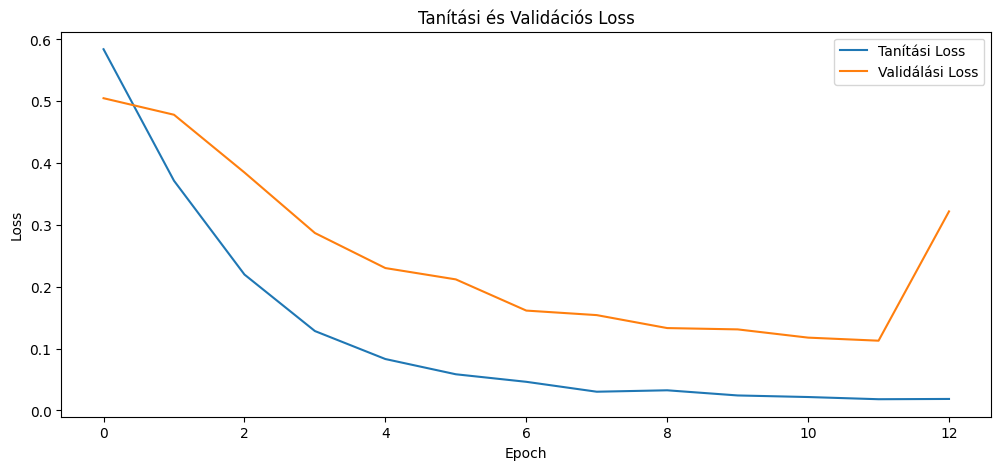

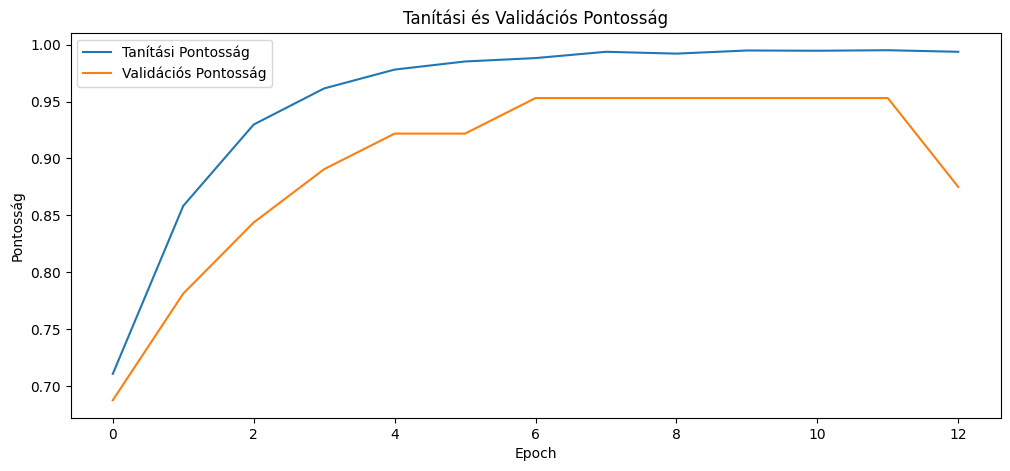

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Tanítási Loss')
plt.plot(val_losses, label='Validálási Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Tanítási és Validációs Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/dementia/lossplot.png')
plt.show()
plt.close()

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Tanítási Pontosság')
plt.plot(val_accuracies, label='Validációs Pontosság')
plt.xlabel('Epoch')
plt.ylabel('Pontosság')
plt.title('Tanítási és Validációs Pontosság')
plt.legend()
plt.savefig('/content/drive/MyDrive/dementia/accplot.png')
plt.show()

In [ ]:
model.save_pretrained("dementia_detection_model")
tokenizer.save_pretrained("dementia_detection_model")

In [ ]:
dementia_test_dict = {key: dementia_dict[key] for key in dementia_test_keys}
control_test_dict = {key: control_dict[key] for key in control_test_keys}

In [ ]:
#Extract the dementia test data
dementia_test = []
for key, value in dementia_test_dict.items():
  for token_list in value:
    dementia_test.append(token_list)
dementia_test_labels = [1] * len(dementia_test)

#extract the control test data
control_test = []
for key, value in control_test_dict.items():
  for token_list in value:
    control_test.append(token_list)
control_test_labels = [0] * len(control_test)

In [ ]:
print("Dementia test length: ")
print(len(dementia_test))
print("Control test length: ")
print(len(control_test))

Dementia test length: 
27
Control test length: 
24


In [ ]:
total_test = dementia_test + control_test
total_test_labels = dementia_test_labels + control_test_labels

In [ ]:
test_dataset = DementiaDataset(total_test, total_test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Device setup (automatically detects GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.nn import BCEWithLogitsLoss
from torch.nn.functional import sigmoid
import torch


loss_fn = BCEWithLogitsLoss()

#test function
def test_model(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)  # Shape: (batch_size,)

            # Compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Convert logits to probabilities
            probs = sigmoid(logits)  # Shape: (batch_size,)

            # Apply threshold to convert probabilities to binary predictions
            preds = (probs > 0.5).int()  # Shape: (batch_size,)

            # Update metrics
            correct_predictions += (preds == labels.int()).sum().item()
            total_samples += labels.size(0)

            # Store predictions and true labels for further analysis if needed
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, predictions, true_labels



In [ ]:
avg_loss, accuracy, predictions, true_labels = test_model(model, test_loader, loss_fn, device)

Test Loss: 0.0716, Test Accuracy: 0.9608


In [ ]:
def extract_cha_file(file_path, tokenizer, max_len=512):
    token_lists = []  # List to store tokenized segments

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter lines that start with *PAR
    par_lines = [line[6:].strip() for line in lines if line.startswith("*PAR:")]

    # Concatenate all *PAR lines into one text
    full_text = " ".join(par_lines)

    # Tokenize the full text
    tokenized = tokenizer(
        full_text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return tokenized

In [ ]:
#manually test model with a random dementia and control sample

import random

predicted_labels = []
true_labels = []
predicted_probs = []

model.eval()
controls = [f for f in os.listdir(control_directory) if os.path.isfile(os.path.join(control_directory, f))]
dementias = [f for f in os.listdir(dementia_directory) if os.path.isfile(os.path.join(dementia_directory, f))]
treshold = 0.42 #0.4790989775210619
for i in range (100):
  rand_control = random.choice(controls)
  rand_dementia = random.choice(dementias)

  control_tokenlists = extract_cha_file(control_directory+"/"+rand_control, tokenizer)
  dementia_tokenlists = extract_cha_file(dementia_directory+"/"+rand_dementia, tokenizer)

  control_tokenized_inputs = {key: val.to(device) for key, val in control_tokenlists.items()}
  dementia_tokenized_inputs = {key: val.to(device) for key, val in dementia_tokenlists.items()}

  true_labels.append(0)
  with torch.no_grad():
      outputs = model(**control_tokenized_inputs)
      logits = outputs.logits
      probs = torch.sigmoid(logits)

  # Get the predicted probability and label
  predicted_prob = probs.item()
  predicted_probs.append(predicted_prob)
  predicted_label = 1 if predicted_prob > 0.5 - treshold else 0
  predicted_labels.append(predicted_label)

  #print("Input: Control")
  #print(f"Predicted Probability: {predicted_prob:.4f}")
  #print(f"Predicted Label: {predicted_label}")
  #print("\n--------------------------------------------------------------------------------------------\n")

  true_labels.append(1)
  with torch.no_grad():
      outputs = model(**dementia_tokenized_inputs)
      logits = outputs.logits
      probs = torch.sigmoid(logits)

  predicted_prob = probs.item()
  predicted_probs.append(predicted_prob)
  predicted_label = 1 if predicted_prob > 0.5 - treshold else 0
  predicted_labels.append(predicted_label)

  #print("Input: Dementia")
  #print(f"Predicted Probability: {predicted_prob:.4f}")
  #print(f"Predicted Label: {predicted_label}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[96  4]
 [ 8 92]]


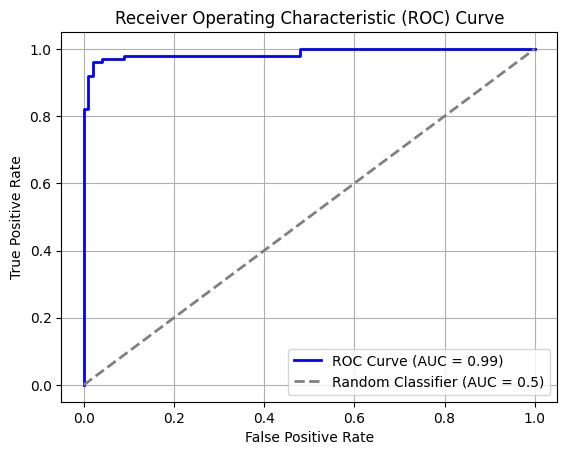

In [ ]:
#ROC curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/dementia/roccurve.png')
plt.grid()
plt.show()

In [ ]:
# Calculate distance to top-left corner
import numpy as np
distance = np.sqrt((1 - tpr)**2 + fpr**2)
best_threshold_index_distance = distance.argmin()
best_threshold_distance = thresholds[best_threshold_index_distance]

best_threshold_distance

0.07731197029352188

In [ ]:
0.5 - best_threshold_distance

0.4226880297064781